环境准备

In [308]:
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [309]:
def set_seed(seed=3407):                   #3407 is all you need!
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(3407)

In [310]:
from tqdm import tqdm

## 最最简单Transformer运行尝试（玩一下先）
使用pytorch官方的nn.Transformer() 和 HuggingFace transformers 库的位置编码

In [311]:
# pip install transformers
!pip show transformers

Name: transformers
Version: 4.46.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: d:\anaconda3\envs\yolov8\lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [312]:
from transformers.models.bert.modeling_bert import BertConfig, BertEmbeddings  # 现成BERT的嵌入层 + 位置编码

In [321]:
# 核心配置: 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")
# 模型维度、多头自注意力的头数
d_model, nhead= 64, 8
# 序列长度、一个批次的大小
sequence_length, batch_size = 10, 8
# 训练轮数、学习率
epochs, lr = 100, 0.001

#------------------------------Transformer------------------------------------
net = nn.Transformer(d_model=d_model, nhead=nhead, batch_first=True).to(device)

#----------------------调用现成的BERT的嵌入层 + 位置编码）--------------------
bert_config = BertConfig(
    vocab_size=10,                            # 词表大小
    hidden_size=d_model,                      # 对应d_model
    max_position_embeddings=sequence_length,  # 最大序列长度
    num_attention_heads=nhead,
)
bert_embeddings = BertEmbeddings(bert_config).to(device)
#-----------------------------------------------------------------------------

fc_out = nn.Linear(d_model, 10).to(device)
#损失函数 和 优化器
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(net.parameters()) + list(fc_out.parameters()), lr=lr)

# 随机数据
input = torch.randint(1, vocab_size, (batch_size, sequence_length)).to(device)  # 避免0（PAD）
target = torch.flip(input, dims=[1]).to(device)  # target是input的逆序
print(input, target, sep="\n")
kokomi_input, kokomi_target = input, target #给全文最后一步对比的

device = cuda
tensor([[2, 8, 6, 9, 8, 1, 4, 4, 3, 1],
        [5, 1, 6, 3, 8, 6, 7, 2, 6, 4],
        [2, 4, 7, 2, 7, 7, 1, 3, 8, 9],
        [6, 2, 7, 2, 8, 5, 8, 5, 3, 2],
        [5, 7, 4, 3, 6, 5, 8, 7, 6, 1],
        [7, 1, 3, 6, 7, 6, 3, 1, 9, 9],
        [7, 9, 2, 3, 4, 3, 8, 2, 7, 3],
        [3, 8, 6, 3, 3, 1, 9, 1, 8, 4]], device='cuda:0')
tensor([[1, 3, 4, 4, 1, 8, 9, 6, 8, 2],
        [4, 6, 2, 7, 6, 8, 3, 6, 1, 5],
        [9, 8, 3, 1, 7, 7, 2, 7, 4, 2],
        [2, 3, 5, 8, 5, 8, 2, 7, 2, 6],
        [1, 6, 7, 8, 5, 6, 3, 4, 7, 5],
        [9, 9, 1, 3, 6, 7, 6, 3, 1, 7],
        [3, 7, 2, 8, 3, 4, 3, 2, 9, 7],
        [4, 8, 1, 9, 1, 3, 3, 6, 8, 3]], device='cuda:0')


In [322]:
net.train()
pbar = tqdm(range(epochs), desc="训练进度")

for epoch in pbar:
    #------------------位置编码--------------------------
    input_embeddings = bert_embeddings(input_ids=input)
    # Decoder输入用target[:, :-1]（右移一位，长度9），避免泄露未来token   (官方的需要)
    target_ = target[:, :-1]
    target_embeddings = bert_embeddings(input_ids=target_)
    #---------------------------------------------------
    
    #--------------几乎通用的训练流程-----------------
    optimizer.zero_grad()
    out = net(input_embeddings, target_embeddings)     #解码器必须接收目标序列才能工作
    out = fc_out(out)                                  #映射到vocab_size（和自定义模型的fc_out对齐）
    loss = criterion(out.reshape(-1, 10), target[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()
    pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    #-----------------------------------------------
    
#没有装flash-attention，报错是正常的

训练进度: 100%|██████████| 100/100 [00:05<00:00, 18.78it/s, Loss=2.0822]


## 一、嵌入层和位置编码

### 嵌入层

嵌入层的核心作用：  
每个 元素 转成 可学习的 高维向量：比如 “我”->[0.1, 0.2, 0.6]

In [323]:
d_model = 16
batch_size = 4
sequence_length = 10
x = torch.randint(0, 10, (batch_size, sequence_length))

embedding = nn.Embedding(num_embeddings=10, embedding_dim=d_model)
X = embedding(x)

x, X.size() #16就是每个元素的向量特征维度

(tensor([[3, 5, 9, 9, 0, 0, 0, 1, 3, 9],
         [5, 2, 0, 3, 0, 5, 3, 5, 8, 1],
         [4, 2, 1, 0, 2, 7, 5, 2, 3, 4],
         [4, 7, 4, 8, 0, 6, 2, 9, 4, 9]]),
 torch.Size([4, 10, 16]))

### 位置编码

Transformer原论文位置编码实现  

PE(pos, 2i)   =  sin(pos / 10000^(2i/d_model))  
PE(pos, 2i+1) =  cos(pos / 10000^(2i/d_model))

In [324]:
class PositionalEncoding(nn.Module):
    #需要参数 ：模型特征维度，丢弃率，最大序列长度（位置维度）（要保证每个元素编码不同，所以必须 >= 原始序列长度）
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # 生成位置编码矩阵 [1, max_len, d_model]
        self.P = torch.zeros(1, max_len, d_model)       #1：batch 维度的占位符（表示 “适配任意 batch 大小”）
        # pos: 第几个 token
        self.pos = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1)

        # i：每个 token 的第几个特征
        #2i/d_model  step=2为偶数索引，对应了2i
        self.two_i_divide_dmodel = torch.arange(0, d_model, step=2, dtype=torch.float32) / d_model
        #10,000^(2i/d_model)
        self.ten_thousands_pow_two_i_divide_dmodel = torch.pow(10000, self.two_i_divide_dmodel)
        #pos / 10000^(2i/d_model)
        self.X = self.pos / self.ten_thousands_pow_two_i_divide_dmodel
        
        #奇数特征位置计算cos，偶数特征位置计算sin
        self.even_cos =torch.cos(self.X)
        self.odd_sin = torch.sin(self.X)
        
        # 0::2 表示从0开始到最后一个位置，步长为2       1::2 表示从1开始到最后一个位置，步长为2
        self.P[:, :, 0::2] = self.odd_sin
        self.P[:, :, 1::2] = self.even_cos

    def forward(self, x):
        #位置编码，因为第二维max_len可能大于x的序列长度，因此要去掉多出的部分，并且放到x所在的设备上
        p = self.P[:,:x.shape[1],:].to(x.device)
        #输入 叠加 位置编码
        x = x + p
        #随机让一部分特征值变为 0，增加泛化能力，提高正则化效果
        return self.dropout(x)

In [325]:
#测试
pos_encoding = PositionalEncoding(d_model=16, dropout=0.1, max_len=10)
print(pos_encoding.P.size())

X_emb = pos_encoding(X)
print(X_emb.size())
# 1 -> 4是因为python的广播机制，4个batch用的是相同的位置编码

torch.Size([1, 10, 16])
torch.Size([4, 10, 16])


## 二、多头自注意力

### 使用官方 自注意力和多头自注意力

In [326]:
self_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=1, batch_first=True)
attention_out, attention_weight = self_attention(
    query=X_emb,    # 查询向量（当前token）
    key=X_emb,      # 键向量（所有token）
    value=X_emb     # 值向量（所有token）
)
#out = 每个 token 融合了序列中所有 token 信息后的最终特征向量
#weight = 每个 token 对其他所有 token 的注意力分数（关注程度）
print(attention_out.size(), attention_weight.size())

torch.Size([4, 10, 16]) torch.Size([4, 10, 10])


In [327]:
self_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True)
attention_out, attention_weight = self_attention(
    query=X_emb,    
    key=X_emb,     
    value=X_emb  
)
print(attention_out.size(), attention_weight.size())

torch.Size([4, 10, 16]) torch.Size([4, 10, 10])


### 手动实现多头自注意力

In [328]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_model, num_heads=1):
        super().__init__()

        self.d_model = d_model               #模型特征维度
        self.num_heads = num_heads           #多头数量
        self.d_head = d_model // num_heads   #每个头的维度（必须整除）  单头时此项为 K的维度
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_out = nn.Linear(d_model, d_model)
        
        #--------------发现loss基本不下降，于是试试初始化------------
        self._init_weights()

    def _init_weights(self):
        """对齐官方nn.MultiheadAttention的初始化逻辑：Xavier均匀分布"""
        for m in [self.w_q, self.w_k, self.w_v, self.w_out]:
            # Xavier初始化：适合线性层+tanh/ReLU激活
            nn.init.xavier_uniform_(m.weight)
            # 偏置初始化为0（官方默认）
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size, sequence_length, d_model = x.shape

        # 步骤1：生成Q、K、V（线性变换）
        Q = self.w_q(x)  # [batch, seq, d_model]
        K = self.w_k(x)  # [batch, seq, d_model]
        V = self.w_v(x)  # [batch, seq, d_model]

        # 步骤2：拆分多头（num_heads=1时，这一步无变化）
        # 维度变为：[batch, num_heads, seq_len, d_head]
        Q = Q.view(batch_size, sequence_length, self.num_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, sequence_length, self.num_heads, self.d_head).transpose(1, 2)
        V = V.view(batch_size, sequence_length, self.num_heads, self.d_head).transpose(1, 2)
        
        # 步骤3：计算注意力分数（Q×K^T / √d_head）
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_head, dtype=torch.float32))
        
        # 步骤4：Softmax归一化（得到注意力权重）
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # 步骤5：注意力加权求和（权重×V）
        attention_output = torch.matmul(attention_weights, V)
        
        # 步骤6：拼接多头
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, self.d_model)
        
        #步骤7：输出线性变换
        attention_output = self.w_out(attention_output)
        
        return attention_output, attention_weights

测试手动实现的多头自注意力

In [329]:
self_attention = MultiHeadAttention(d_model=d_model, num_heads=2)
attention_out, attention_weight = self_attention(X_emb)
print(attention_out.size(), attention_weight.size())

torch.Size([4, 10, 16]) torch.Size([4, 2, 10, 10])


### 使用 Einops 手动实现多头自注意力

In [330]:
from einops import rearrange, einsum

class EinopsMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads=1):
        super().__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads  

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_out = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, sequence_length, d_model = x.shape

        #步骤 1不变
        Q = self.w_q(x)  # [batch, seq, d_model]
        K = self.w_k(x)  # [batch, seq, d_model]
        V = self.w_v(x)  # [batch, seq, d_model]
        
        # ===================== 步骤 2：拆分多头（einops rearrange 替代 view+transpose） =====================
        Q = rearrange(Q, 'b s (h d) -> b h s d', h=self.num_heads, d=self.d_head)  # [b, h, s, d]
        K = rearrange(K, 'b s (h d) -> b h s d', h=self.num_heads, d=self.d_head)  # [b, h, s, d]
        V = rearrange(V, 'b s (h d) -> b h s d', h=self.num_heads, d=self.d_head)  # [b, h, s, d]
        
        # ===================== 步骤 3：计算Q×K^T（einops einsum 替代 matmul+transpose） =====================
        # 语法：einsum(张量1, 模式1, 张量2, 模式2, 输出模式)
        # Q模式：b h s1 d → K模式：b h s2 d → 输出：b h s1 s2（s1=query_seq, s2=key_seq） 通过d相乘
        attention_scores = einsum(Q, K, 'b h s1 d, b h s2 d -> b h s1 s2') / torch.sqrt(torch.tensor(self.d_head, dtype=torch.float32))

        #步骤 4不变
        attention_weights = F.softmax(attention_scores, dim=-1)  # [b, h, s1, s2]
        
        #步骤 5不变
        attention_output = torch.matmul(attention_weights, V)
        
        # ===================== 步骤 6：拼接多头（einops rearrange 替代 transpose+view+contiguous） =====================
        attention_output = rearrange(attention_output, 'b h s d -> b s (h d)')  # [b, s, d_model]
        
        #步骤 7不变
        attention_output = self.w_out(attention_output)
        
        return attention_output, attention_weights

测试使用 Einops 手动实现的多头自注意力

In [331]:
self_attention = EinopsMultiHeadAttention(d_model=d_model, num_heads=4)
attention_out, attention_weight = self_attention(X_emb)
print(attention_out.size(), attention_weight.size())

torch.Size([4, 10, 16]) torch.Size([4, 4, 10, 10])


## 三、编码器

### 使用官方nn.TransformerEncoder

In [332]:
d_model = 16
num_heads = 4
batch_size = 4
ffn_dim = 256
dropout = 0.1
num_layers = 4
sequence_length = 20
max_len = sequence_length
vocab_size = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备：{device}")

encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=num_heads,
    dim_feedforward=ffn_dim,
    dropout=dropout,
    batch_first=True,  # 重点：设置batch在前，否则默认是[seq, batch, d_model]
    activation="relu",  # 激活函数（原论文用relu）
    device=device
)

transformer_encoder = nn.TransformerEncoder(
    encoder_layer=encoder_layer,
    num_layers=num_layers,
    norm=nn.LayerNorm(d_model).to(device)  # 最终层归一化（可选）
)

#随机生成输入
x = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)
print(f"x: {x}")
#输入嵌入
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model).to(device)
X = embedding(x)

#使用我们的位置编码
pos_encoding = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len).to(device)
X_emb = pos_encoding(X)
print(f"X_emb: {X_emb.size()}")

#调用官方 TransformerEncoder
encoder_out = transformer_encoder(X_emb, mask=None)

# ===================== 打印结果验证 =====================
print("\n============ 官方 TransformerEncoder 输出 ============")
print(f"编码器最终输出维度：{encoder_out.shape} → 预期 [4, 20, 16]")
print(f"输出数据类型：{encoder_out.dtype}")
print(f"输出设备：{encoder_out.device}")

# 可选：查看编码器的参数数量（验证参数被正确初始化）
total_params = sum(p.numel() for p in transformer_encoder.parameters())
print(f"\n编码器总参数数：{total_params}")

使用设备：cuda
x: tensor([[7, 1, 8, 5, 7, 8, 3, 7, 2, 2, 1, 2, 9, 5, 8, 0, 4, 4, 0, 4],
        [6, 8, 1, 9, 4, 2, 2, 8, 3, 8, 6, 0, 4, 2, 3, 7, 6, 4, 6, 8],
        [0, 8, 1, 1, 5, 3, 1, 8, 1, 8, 1, 1, 6, 2, 5, 7, 0, 7, 9, 9],
        [8, 4, 1, 9, 1, 9, 9, 3, 3, 3, 3, 6, 6, 3, 5, 4, 4, 5, 0, 9]],
       device='cuda:0')
X_emb: torch.Size([4, 20, 16])

============ 官方 TransformerEncoder 输出 ============
编码器最终输出维度：torch.Size([4, 20, 16]) → 预期 [4, 20, 16]
输出数据类型：torch.float32
输出设备：cuda:0

编码器总参数数：38496


### 单层编码器手动版

In [333]:
class EncoderLayer(nn.Module):
    #参数： 模型特征维度、多头数、前馈网络特征维度、丢弃率
    def __init__(self, d_model, num_heads, ffn_dim=1024, dropout=0.1):
        super().__init__()
        
        # 多头自注意力：使用第二章的代码
        self.self_attn = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        
        # 前馈网络（FFN：Linear → ReLU → Dropout → Linear）
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_dim),  # 升维（原论文ff_dim=4*d_model）
            nn.ReLU(),                    # 激活
            nn.Dropout(dropout),          # 丢弃一些，正则化效果提升
            nn.Linear(ffn_dim, d_model)   # 降维回d_model
        )
        
        # 层归一化（Pre-LN模式：先归一化，再做注意力/FFN）
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout（残差连接后）
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # 第一步：层归一化 + 多头自注意力 + 残差连接
        x_norm = self.norm1(x)
        attn_out, attn_weights = self.self_attn(x_norm)
        # 残差连接：输入 x + 注意力输出（加dropout）
        x = x + self.dropout1(attn_out)

        # 第二步：层归一化 + 前馈网络 + 残差连接
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm)
        # 残差连接：当前 x + FFN输出（加dropout）
        x = x + self.dropout2(ffn_out)

        return x, attn_weights

### 完整编码器手动版

In [334]:
class Encoder(nn.Module):
    #参数：模型特征维度、多头数、词表大小（语言模型用）、层数、前馈网络特征维度、丢弃率、最大序列长度（建议=序列长度）
    def __init__(self, d_model, num_heads, vocab_size, num_layers, ffn_dim=2048, dropout=0.1, max_len=1000):
        super().__init__()
        
        self.d_model = d_model
        # 1. 嵌入层（token → d_model维向量）
        self.embedding = nn.Embedding(vocab_size, d_model)
        # 2. 位置编码（添加位置信息） 用的第一章实现的位置编码器
        self.pos_encoding = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len)
        
        # 3. 多层编码器层（堆叠num_layers层）
        layer_list = []
        for _ in range(num_layers):
            layer = EncoderLayer(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, dropout=dropout)
            layer_list.append(layer)
        self.layers = nn.ModuleList(layer_list)
        #也可以用列表推导式，如下所示：
        # self.layers = nn.ModuleList([
        #     EncoderLayer(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, dropout=dropout)
        #     for _ in range(num_layers)
        # ])
        
        # 4. 最终层归一化（可选，提升稳定性）
        self.final_norm = nn.LayerNorm(d_model)
        
        #--------------发现loss基本不下降，于是试试初始化------------
        self._init_weights()

    def _init_weights(self):
        """初始化嵌入层+层归一化（可选）"""
        # 嵌入层：Xavier初始化（和注意力层一致）
        nn.init.xavier_uniform_(self.embedding.weight)
        # 层归一化默认初始化已足够，无需额外操作

    def forward(self, x):
        # 步骤1：嵌入层 + 缩放（原论文：embedding输出 × √d_model，平衡位置编码幅度）
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        
        # 步骤2：添加位置编码
        x = self.pos_encoding(x)
        
        # 步骤3：堆叠编码器层
        all_attention_weights = []
        for layer in self.layers:
            x, attention_weights = layer(x)
            all_attention_weights.append(attention_weights)
            
        # 步骤4：最终层归一化
        encoder_out = self.final_norm(x)
        
        return encoder_out

### 测试手动实现的编码器

In [335]:
d_model = 16
batch_size = 4
sequence_length = 10

encoder = Encoder(
    vocab_size = 10,
    d_model = d_model,
    num_heads = 4,
    num_layers = 4,
    ffn_dim = 256,
    dropout = 0.1,
    max_len = sequence_length
)

x = torch.randint(0, 10, (batch_size, sequence_length))
print(x)

encoder_out = encoder(x)

print(f"编码器最终输出维度：{encoder_out.shape} → 预期 [4, 10, 16]")
print(f"输出数据类型：{encoder_out.dtype}")
print(f"输出设备：{encoder_out.device}")

# 可选：查看编码器的参数数量（验证参数被正确初始化）
total_params = sum(p.numel() for p in encoder.parameters())
print(f"\n编码器总参数数：{total_params}")

tensor([[0, 4, 2, 5, 7, 7, 1, 9, 2, 1],
        [5, 6, 4, 6, 8, 1, 8, 9, 4, 5],
        [3, 0, 7, 2, 7, 2, 0, 7, 9, 5],
        [6, 7, 9, 5, 8, 4, 3, 3, 3, 4]])
编码器最终输出维度：torch.Size([4, 10, 16]) → 预期 [4, 10, 16]
输出数据类型：torch.float32
输出设备：cpu

编码器总参数数：38656


## 四、解码器

### 使用官方nn.TransformerDecoder

In [336]:
# 解码器专属参数
target_seq_length = 18  # 解码器目标序列长度（通常比编码器短/等长，测试用18）

decoder_layer = nn.TransformerDecoderLayer(
    d_model=d_model,
    nhead=num_heads,
    dim_feedforward=ffn_dim,
    dropout=dropout,
    batch_first=True,  # 输入维度 [batch, seq, d_model]
    activation="relu",
    device=device
)

transformer_decoder = nn.TransformerDecoder(
    decoder_layer=decoder_layer,
    num_layers=num_layers,
    norm=nn.LayerNorm(d_model).to(device)  # 最终层归一化
)

memory = transformer_encoder(X_emb, mask=None)
print(f"编码器输出（memory）维度：{memory.shape} → [batch, src_seq, d_model]")

编码器输出（memory）维度：torch.Size([4, 20, 16]) → [batch, src_seq, d_model]


In [337]:
# 生成解码器目标输入（tgt_x）
target_x = torch.randint(0, vocab_size, (batch_size, target_seq_length)).to(device)
print(f"\n解码器目标输入（target_x）维度：{target_x.shape}")

# 解码器输入处理（嵌入+位置编码）
target_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=d_model).to(device)
target_X = target_embedding(target_x)

target_pos_encoding = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len).to(device)
target_X_emb = target_pos_encoding(target_X)

print(f"解码器嵌入+位置编码后维度：{target_X_emb.shape}")

# 生成解码器关键掩码（核心！）
# 掩码1：未来掩码（look-ahead mask）→ 防止解码器看到当前token之后的内容
def generate_square_subsequent_mask(target_seq_length, device=device):
    # 生成全 1矩阵
    all_1 = torch.ones((target_seq_length, target_seq_length), device=device)
    # 将全 1矩阵 转换为 上三角全 1矩阵
    upper_triangle = torch.triu(all_1)
    # 将上三角全 1矩阵 转换成 上三角布尔值矩阵 然后 行列互换 变成 下三角布尔值矩阵
    mask = (upper_triangle == 1).transpose(0, 1)
    # 转float格式
    mask = mask.float()
    # 0的位置填充成-inf    1的位置填充成0   得到注意力掩码
    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, float(0.0))
    return mask

target_mask = generate_square_subsequent_mask(target_seq_length, device)
print(f"\n未来掩码（target_mask）维度：{target_mask.shape}")

# 掩码2：memory掩码（编码器输出掩码）→ 测试时设为None（无掩码）
memory_mask = None

decoder_out = transformer_decoder(tgt=target_X_emb, memory=memory, tgt_mask=target_mask, memory_mask=memory_mask)

# ===================== 7. 验证输出 =====================
print("\n============ 官方 TransformerDecoder 输出 =============")
print(f"解码器最终输出维度：{decoder_out.shape} → 预期 [4, 18, 16]")
print(f"输出数据类型：{decoder_out.dtype}")
print(f"输出设备：{decoder_out.device}")
# 查看编码器的参数数量
total_params = sum(p.numel() for p in transformer_encoder.parameters())
print(f"\n编码器总参数数：{total_params}")
# 查看解码器参数数量
total_decoder_params = sum(p.numel() for p in transformer_decoder.parameters())
print(f"解码器总参数数：{total_decoder_params}")
print(f"编码器+解码器总参数数：{total_decoder_params + sum(p.numel() for p in transformer_encoder.parameters())}")


解码器目标输入（target_x）维度：torch.Size([4, 18])
解码器嵌入+位置编码后维度：torch.Size([4, 18, 16])

未来掩码（target_mask）维度：torch.Size([18, 18])

============ 官方 TransformerDecoder 输出 =============
解码器最终输出维度：torch.Size([4, 18, 16]) → 预期 [4, 18, 16]
输出数据类型：torch.float32
输出设备：cuda:0

编码器总参数数：38496
解码器总参数数：42976
编码器+解码器总参数数：81472


### 单层解码器手动版

注意力掩码

In [338]:
#注意力掩码 / Look-Ahead Mask（前瞻掩码）/ Future Mask（未来掩码）
def generate_square_subsequent_mask(target_seq_length, device=device):
    # 生成全 1矩阵
    all_1 = torch.ones((target_seq_length, target_seq_length), device=device)
    # 将全 1矩阵 转换为 上三角全 1矩阵
    upper_triangle = torch.triu(all_1)
    # 将上三角全 1矩阵 转换成 上三角布尔值矩阵 然后 行列互换 变成 下三角布尔值矩阵
    mask = (upper_triangle == 1).transpose(0, 1)
    # 转float格式
    mask = mask.float()
    # 0的位置填充成-inf    1的位置填充成0   得到注意力掩码
    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, float(0.0))
    return mask.unsqueeze(0) #扩展到(1, target_seq_length, target_seq_length)   适配batchsize
    
generate_square_subsequent_mask(3)

tensor([[[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]]], device='cuda:0')

记忆掩码（测试时设置None即可）

In [339]:
#实际业务中，不是所有样本的源序列都能填满 20 个 token（比如有的样本只有 15 个有效 token，剩下 5 个是 <PAD> 填充
#解码器的交叉注意力层需要 “关注编码器的有效 token，忽略 <PAD>”—— 这就是 generate_input_target_mask 的核心价值

#Memory Mask（记忆掩码）/ Source-Target Padding Mask（源 - 目标填充掩码）/ Encoder Output Mask（编码器输出掩码）
def generate_input_target_mask(input_padding_mask, target_seq_length, device=device):
    batch_size, input_seq_length = input_padding_mask.shape
    # # 1. padding掩码：False→PAD位置，True→有效位置
    padding_mask = input_padding_mask
    # 2. 扩展维度：[batch, 1, target_seq, src_seq] → 适配交叉注意力的维度 [batch, num_heads, target_seq, src_seq]
    mask = padding_mask.unsqueeze(1).expand(-1, target_seq_length, -1)
    # 3. 填充-inf（让softmax后权重为0），0（有效位置）
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, 0.0)
    return mask.to(device)

#源序列padding掩码：[batch, seq_len] = [4,20]
input_padding_mask = torch.tensor([
    [True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False],  
    [True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False],  
    [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False], 
    [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True], 
]).to(device)

input_target_mask = generate_input_target_mask(input_padding_mask, target_seq_length=18, device=device)
print(input_target_mask.shape)

torch.Size([4, 18, 20])


多头掩码自注意力（对多头注意力修改了两个地方）

In [340]:
#多头掩码注意力（两处修改）
class EinopsMultiHeadMaskAttention(nn.Module):
    def __init__(self, d_model, num_heads=1):
        super().__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads  

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_out = nn.Linear(d_model, d_model)

        #--------------发现loss基本不下降，于是试试初始化------------
        self._init_weights()

    def _init_weights(self):
        """Xavier初始化：适配线性层+注意力的数值分布"""
        for m in [self.w_q, self.w_k, self.w_v, self.w_out]:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, q, k, v, mask=None):  # 改动1：输入改为q/k/v，增加mask参数              
        # -------------兼容q/k/v序列长度不同的场景（如交叉注意力：q=tgt_seq, k/v=src_seq）------------------
        batch_size =q.shape[0] 
        seq_len_q = q.shape[1]
        seq_len_k = k.shape[1]
        # 步骤 1：线性变换生成Q/K/V（逻辑不变，输入从x改为q/k/v）
        Q = self.w_q(q)  # [batch, seq_q, d_model]
        K = self.w_k(k)  # [batch, seq_k, d_model]
        V = self.w_v(v)  # [batch, seq_k, d_model]
        # ----------------------------------------------------------------------------------------------
        
        # 步骤 2：拆分多头（einops rearrange 替代 view+transpose，逻辑不变）
        Q = rearrange(Q, 'b s (h d) -> b h s d', h=self.num_heads, d=self.d_head)  # [b, h, seq_q, d_head]
        K = rearrange(K, 'b s (h d) -> b h s d', h=self.num_heads, d=self.d_head)  # [b, h, seq_k, d_head]
        V = rearrange(V, 'b s (h d) -> b h s d', h=self.num_heads, d=self.d_head)  # [b, h, seq_k, d_head]
        
        # 步骤 3：计算Q×K^T（einops einsum，适配seq_q/seq_k不同长度）不变
        # 注意：输出维度变为 [b, h, seq_q, seq_k]（兼容交叉注意力）
        attention_scores = einsum(Q, K, 'b h s1 d, b h s2 d -> b h s1 s2') 
        # 优化：指定device避免CPU/GPU不匹配，同时除以√d_head
        attention_scores = attention_scores / torch.sqrt(torch.tensor(self.d_head, dtype=torch.float32, device=Q.device))

        # --------------------------步骤 4：新增——应用掩码（解码器核心需求）------------------------------
        if mask is not None:
            # mask维度要求：[batch, 1, seq_q, seq_k] 或 [batch, num_heads, seq_q, seq_k]（einops自动广播）
            attention_scores = attention_scores + mask
        # ---------------------------------------------------------------------------------------------
        
        # 步骤 5：Softmax归一化（逻辑不变）
        attention_weights = F.softmax(attention_scores, dim=-1)  # [b, h, seq_q, seq_k]
        
        # 步骤 6：注意力加权求和（逻辑不变）
        attention_output = torch.matmul(attention_weights, V)  # [b, h, seq_q, d_head]
        
        # 步骤 7：拼接多头（einops rearrange，逻辑不变）
        attention_output = rearrange(attention_output, 'b h s d -> b s (h d)')  # [b, seq_q, d_model]
        
        # 步骤 8：输出线性变换（逻辑不变）
        attention_output = self.w_out(attention_output)
        
        return attention_output, attention_weights

In [341]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ffn_dim, dropout=0.1):
        super().__init__()
        # 1. 掩码多头自注意力（屏蔽未来位置）
        self.self_attn = EinopsMultiHeadMaskAttention(d_model, num_heads)
        # 2. 编码器-解码器注意力（关注编码器输出）
        self.cross_attn = EinopsMultiHeadMaskAttention(d_model, num_heads)
        # 3. 前馈网络
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ffn_dim),  # 升维（原论文ff_dim=4*d_model）
            nn.ReLU(),                    # 激活
            nn.Dropout(dropout),          # 丢弃一些，正则化效果提升
            nn.Linear(ffn_dim, d_model)   # 降维回d_model
        )
        
        # 层归一化（每层注意力/前馈后都要做）
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropout（可选，增强鲁棒性）
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, target, encoder_out, target_mask=None, input_target_mask=None):
        
        #第一步：层归一化 + 多头掩码自注意力 + 残差连接   层归一化也可以在最后
        target_norm = self.norm1(target)
        mask_attention_out, mask_attention_weights = self.self_attn(target_norm, target_norm, target_norm, mask=target_mask)
        # 残差连接：输入 x + 注意力输出（加dropout）
        target = target + self.dropout1(mask_attention_out)

        ## 第二步：层归一化 + 多头交叉掩码自注意力 + 残差连接   层归一化也可以在最后
        target_norm = self.norm2(target)
        # K和 V改成编码器输出的
        cross_attention_out, cross_attention_weights = self.cross_attn(target_norm, encoder_out, encoder_out, mask=input_target_mask)
        # 残差连接：输入 x + 注意力输出（加dropout）
        target = target + self.dropout2(cross_attention_out)

        # 第三步：层归一化 + 前馈网络 + 残差连接
        target_norm = self.norm3(target)
        ffn_out = self.ffn(target_norm)
        # 残差连接：当前 x + FFN输出（加dropout）
        target = target + self.dropout3(ffn_out)

        return target

### 完整解码器手动版

In [342]:
class Decoder(nn.Module):
    #参数不再介绍了，同编码器
    def __init__(self, d_model, num_heads, vocab_size, num_layers, ffn_dim=2048, dropout=0.1, max_len=1000):
        super().__init__()

        self.d_model = d_model
        # 1. 目标序列词嵌入层（token → d_model维向量）
        self.target_embedding = nn.Embedding(vocab_size, d_model)
        # 2. 位置编码（添加位置信息） 用的第一章实现的位置编码器
        self.pos_encoding = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len)
        
        # 3. 多层解码器层（堆叠num_layers层）
        layer_list = []
        for _ in range(num_layers):
            layer = DecoderLayer(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, dropout=dropout)
            layer_list.append(layer)
        self.layers = nn.ModuleList(layer_list)
        #也可以用列表推导式，如下所示：
        # self.layers = nn.ModuleList([
        #     DecoderLayer(d_model, n_heads, ffn_dim, dropout)
        #     for _ in range(num_layers)
        # ])
        
        # 4. 最终线性层（将d_model映射到词表大小，用于预测token）
        self.fc_out = nn.Linear(d_model, vocab_size)
        
        # 5. Dropout（可选，增强鲁棒性）
        self.dropout = nn.Dropout(dropout)  
        
        #--------------发现loss基本不下降，于是试试初始化------------
        self._init_weights()

    def _init_weights(self):
        """初始化嵌入层和最终预测层"""
        # 嵌入层初始化
        nn.init.xavier_uniform_(self.target_embedding.weight)
        # 最终预测层初始化
        nn.init.xavier_uniform_(self.fc_out.weight)
        if self.fc_out.bias is not None:
            nn.init.zeros_(self.fc_out.bias)
        
    def forward(self, target, encoder_out, target_mask=None, input_target_mask=None):
        batch_size, seq_len = target.shape
        
        # 步骤1：词嵌入 + 缩放（论文要求：embedding输出 × √d_model，平衡位置编码量级）
        target = self.target_embedding(target) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        
        # 步骤2：叠加位置编码
        target = self.pos_encoding(target) 
        
        # 步骤3：逐层通过解码器层
        for layer in self.layers:
            target = layer(target, encoder_out, target_mask, input_target_mask)
        
        # 步骤4：最终线性层（映射到词表大小，用于预测下一个token）
        # 【注意】不做softmax：训练时CrossEntropyLoss内部包含softmax，避免重复计算
        decoder_output = target
        fc_output = self.fc_out(target)
        
        return decoder_output, fc_output

### 测试手动实现的解码器

In [343]:
target_x = torch.randint(0, vocab_size, (batch_size, target_seq_length)).to(device)
print(f"\n解码器目标输入（target_x）维度：{target_x.shape}")

# 掩码1：未来掩码（look-ahead mask）→ 防止解码器看到当前token之后的内容
target_mask = generate_square_subsequent_mask(target_seq_length, device)
print(f"\n未来掩码（target_mask）维度：{target_mask.shape}")

# 掩码2：memory掩码（编码器输出掩码）→ 测试时设为None（无掩码）
memory_mask = None


decoder = Decoder(
    d_model=d_model,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    num_layers=num_layers,
    vocab_size=vocab_size,
    dropout=0.1,
    max_len=target_seq_length
).to(device)
decoder_out, fc_out = decoder(target=target_x, encoder_out=memory, target_mask=target_mask, input_target_mask=memory_mask)

# ===================== 7. 验证输出 =====================
print("\n============ 我们的 TransformerDecoder 输出 =============")
print(f"解码器输出维度：{decoder_out.shape} → 预期 [4, 18, 16]")
print(f"输出数据类型：{decoder_out.dtype}")
print(f"输出设备：{decoder_out.device}")
print(f"特征映射到词表后的最终输出维度：{fc_out.shape} → 预期 [4, 18, 10]")
# 查看编码器的参数数量
total_params = sum(p.numel() for p in transformer_encoder.parameters())
print(f"\n编码器总参数数：{total_params}")
# 查看解码器参数数量
total_decoder_params = sum(p.numel() for p in transformer_decoder.parameters())
print(f"解码器总参数数：{total_decoder_params}")
print(f"编码器+解码器总参数数：{total_decoder_params + sum(p.numel() for p in transformer_encoder.parameters())}")


解码器目标输入（target_x）维度：torch.Size([4, 18])

未来掩码（target_mask）维度：torch.Size([1, 18, 18])

============ 我们的 TransformerDecoder 输出 =============
解码器输出维度：torch.Size([4, 18, 16]) → 预期 [4, 18, 16]
输出数据类型：torch.float32
输出设备：cuda:0
特征映射到词表后的最终输出维度：torch.Size([4, 18, 10]) → 预期 [4, 18, 10]

编码器总参数数：38496
解码器总参数数：42976
编码器+解码器总参数数：81472


## 五、Transformer

### Transformer手动实现

回顾一下之前的模块名   

嵌入层：nn.Embedding   
位置编码：PositionalEncoding   

Einops实现的多头自注意力：EinopsMultiHeadAttention   
编码器层：EncoderLayer   
编码器：Encoder  

注意力掩码：generate_square_subsequent_mask  
记忆掩码：generate_input_target_mask  
多头掩码自注意力：EinopsMultiHeadMaskAttention  
解码器层：DecoderLayer  
解码器：Decoder  

In [344]:
class Transformer(nn.Module):
    #参数不解释了
    def __init__(self, d_model, num_heads, ffn_dim, num_layers, vocab_size, max_len, dropout=0.1):
        super().__init__()
        #编码器
        self.encoder = Encoder(
            d_model=d_model,
            num_heads=num_heads,
            ffn_dim=ffn_dim,
            num_layers=num_layers,
            vocab_size=vocab_size,
            max_len=max_len,
            dropout=dropout
        )
        #解码器
        self.decoder = Decoder(
            d_model=d_model,
            num_heads=num_heads,
            ffn_dim=ffn_dim,
            num_layers=num_layers,
            vocab_size=vocab_size,
            max_len=max_len,
            dropout=dropout
        )

    def forward(self, x, target, target_mask=None, input_target_mask=None):
        # 1. 先编码 # [batch, src_seq_len, d_model]
        encoder_out = self.encoder(x) 
        # 2. 后解码 # [batch, target_seq_len, vocab_size]
        decoder_out, fc_out = self.decoder(target, encoder_out, target_mask, input_target_mask)  
        return decoder_out, fc_out

### 测试手动实现的Transformer

In [345]:
# 0.设置参数
d_model = 16                  #模型特征维度
num_heads = 4                 #多头数
batch_size = 4                #一个批次的大小
ffn_dim = 256                 #前馈网络特征维度
dropout = 0.1                 #丢弃率
num_layers = 4                #编码器和解码器的层数
sequence_length = 20          #序列长度
max_len = sequence_length     #最大序列长度，最好=序列长度
vocab_size = 10               #词表大小（语言类用）
target_seq_length = 18        #目标序列长度

# 1. 初始化完整Transformer
transformer = Transformer(
    d_model=d_model,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    num_layers=num_layers,
    vocab_size=vocab_size,
    max_len=max_len,
    dropout=dropout
).to(device)

# 2. 生成测试输入
# 编码器输入（src）：[batch, seq_len]
x = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)
# 解码器输入（target）：[batch, target_seq_len]
target = torch.randint(0, vocab_size, (batch_size, target_seq_length)).to(device)
# 模拟编码器PAD掩码 1：有效，  0：<PAD>
input_padding_mask = torch.tensor([
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
]).to(device)

# 3. 生成掩码
target_mask = generate_square_subsequent_mask(target_seq_length, device)  # [18,18]
input_target_mask = generate_input_target_mask(input_padding_mask, target_seq_length, device)  # [4,18,20]

# 4. 前向传播
output, fc_out = transformer(x, target, target_mask, input_target_mask)

# 5. 维度验证
print("="*50)
print(f"编码器输入（x）维度：{x.shape} → [4,20]")
print(f"解码器输入（target）维度：{target.shape} → [4,18]")
print(f"编码器PAD掩码维度：{input_padding_mask.shape} → [4,20]")
print(f"注意力掩码（target_mask）维度：{target_mask.shape} → [18,18]")
print(f"记忆掩码（input_target_mask）维度：{input_target_mask.shape} → [4,18,20]")
print(f"Transformer输出维度：{output.shape} → 预期[4,18,16]")
print(f"特征映射到词表后的最终输出维度：{fc_out.shape} → 预期 [4, 18, 10]")
print("="*50)

# 6. 验证参数设备
print(f"模型设备：{next(transformer.parameters()).device}")
print(f"输出设备：{output.device}")
# 查看参数数量 81930
total_params = sum(p.numel() for p in transformer.parameters())
print(f"\n总参数数：{total_params}")

编码器输入（x）维度：torch.Size([4, 20]) → [4,20]
解码器输入（target）维度：torch.Size([4, 18]) → [4,18]
编码器PAD掩码维度：torch.Size([4, 20]) → [4,20]
注意力掩码（target_mask）维度：torch.Size([1, 18, 18]) → [18,18]
记忆掩码（input_target_mask）维度：torch.Size([4, 18, 20]) → [4,18,20]
Transformer输出维度：torch.Size([4, 18, 16]) → 预期[4,18,16]
特征映射到词表后的最终输出维度：torch.Size([4, 18, 10]) → 预期 [4, 18, 10]
模型设备：cuda:0
输出设备：cuda:0

总参数数：81930


### 测试手动的Transformer训练数据

In [346]:
#可视化
import matplotlib.pyplot as plt

device = cuda


训练进度: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s, Loss=0.0905]


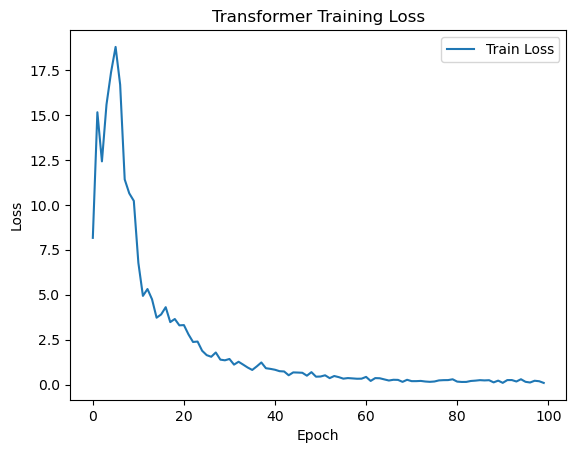

In [347]:
# 核心配置: 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

# 0.设置参数   同最开始的
d_model = 64                  #模型特征维度
num_heads = 8                 #多头数
batch_size = 8                #一个批次的大小
ffn_dim = 2048                #前馈网络特征维度
dropout = 0.1                 #丢弃率
num_layers = 6                #编码器和解码器的层数
sequence_length = 10          #序列长度
max_len = sequence_length     #最大序列长度，最好=序列长度
vocab_size = 10               #词表大小（语言类用）
target_seq_length = 10        #目标序列长度

epochs = 100                  # 训练轮数
lr = 1e-3                     # 学习率
pad_idx = 0                   # PAD token索引（损失函数忽略）

input = kokomi_input.to(device)     #和最前面的 玩一下 同一个输入
target = kokomi_target.to(device)   #和最前面的 玩一下 同一个输入

model = Transformer(
    d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim,
    num_layers=num_layers, vocab_size=vocab_size, max_len=max_len, dropout=dropout
).to(device)

# 损失函数：CrossEntropyLoss（忽略PAD token）
criterion = nn.CrossEntropyLoss()

# 优化器：Adam（Transformer经典优化器）
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()  # 切换训练模式

# 记录Loss变化
train_losses = []
pbar = tqdm(range(epochs), desc="训练进度")

for epoch in pbar:
    optimizer.zero_grad()  # 清空梯度

    target_new = target[:, :-1]  # Decoder输入：[8,9]  少了一位
    # target_target = target[:, 1:]  # Loss计算目标：[8,9]
    
    target_mask = generate_square_subsequent_mask(target_seq_length-1, device)  # [18,18]
    # input_target_mask = generate_input_target_mask(input_padding_mask, target_seq_length, device)  # [4,18,20]

    # 前向传播
    output, fc_out = model(input, target_new, target_mask, input_target_mask=None)

    # 计算Loss（调整维度：[batch, seq_len, vocab] → [batch*seq_len, vocab]）
    loss = criterion(
        fc_out.reshape(-1, vocab_size),  
        target[:, 1:].reshape(-1)        
    )

    # 反向传播 + 梯度裁剪 + 优化
    loss.backward()
    optimizer.step()
    pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    # 记录Loss
    train_losses.append(loss.item())

    # # 5. 保存模型（可选）
    # torch.save(model.state_dict(), 'transformer_model.pth')
    # print("\n✅ 训练完成！模型已保存为 transformer_model.pth")

# 4. 可视化Loss变化
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer Training Loss')
plt.legend()
plt.show()